### Example training

Only the first cell is relevant. The remaining cells are personal tests.

In [ ]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train
import train_lightning
import torchtrainer
import numpy as np

params = {
    # Dataset
    'img_dir': Path('H:/datasets/segmentation/vessel/maximum_projection/images'),
    'label_dir': Path('H:/datasets/segmentation/vessel/maximum_projection/labels'),
    'crop_size': (256, 256),          
    'train_val_split': 0.1,
    'use_transforms': False,
    # Model
    'model_layers': (3, 3, 3), 
    'model_channels': (16,32,64), 
    'use_unet': True,
    # Training
    'epochs': 1,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, #132,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.367, 0.633),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs_unet',
    'experiment':'unet_l_3_c_16_32_64',
    'save_best':True,
    # Other
    'resume': False,
}

#t0 = time.time()
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train.run(params)
#Train using Pytorch Lightning
ds_train, ds_valid, model, trainer = train_lightning.run(params)
#print(time.time()-t0)

In [39]:
model = train_lightning.LitSeg.load_from_checkpoint('models/unet_l_3_c_16_32_64_epochs_30_val_loss_0145.ckpt', meta={})
model.eval()
model.to('cuda')

LitSeg(
  (loss_func): CrossEntropyLoss()
  (model): ResUNet(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (encoder): ModuleDict(
      (stage_0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [40]:
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


[(0, tensor(-1136.8878), tensor(50.8457)),
 (1, tensor(-465.5320), tensor(33.1193)),
 (2, tensor(-341.0240), tensor(39.5839)),
 (3, tensor(-231.8551), tensor(38.6833)),
 (4, tensor(-456.3341), tensor(38.7240)),
 (5, tensor(-126.8626), tensor(39.1160)),
 (6, tensor(-207.8259), tensor(43.4029)),
 (7, tensor(-1071.7819), tensor(29.8280)),
 (8, tensor(-411.8535), tensor(29.3458)),
 (9, tensor(-312.9150), tensor(30.6996)),
 (10, tensor(-475.9815), tensor(29.4272)),
 (11, tensor(-501.8924), tensor(25.9161)),
 (12, tensor(-379.2554), tensor(30.8207)),
 (13, tensor(-418.3698), tensor(28.9400)),
 (14, tensor(-302.7916), tensor(29.5098)),
 (15, tensor(-347.6111), tensor(27.2718)),
 (16, tensor(-533.5453), tensor(28.3376)),
 (17, tensor(-709.6705), tensor(35.8297)),
 (18, tensor(-480.8862), tensor(32.6888)),
 (19, tensor(-226.4244), tensor(27.8853)),
 (20, tensor(-798.8602), tensor(35.1848)),
 (21, tensor(-348.1897), tensor(24.9410)),
 (22, tensor(-352.8672), tensor(29.3288)),
 (23, tensor(-830.6

In [41]:
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
stats

In [42]:
stats

[(0,
  ('iou', tensor(0.9170)),
  ('prec', tensor(0.9769)),
  ('rec', tensor(0.9373))),
 (1,
  ('iou', tensor(0.8974)),
  ('prec', tensor(0.9067)),
  ('rec', tensor(0.9887))),
 (2,
  ('iou', tensor(0.9141)),
  ('prec', tensor(0.9416)),
  ('rec', tensor(0.9690))),
 (3,
  ('iou', tensor(0.9265)),
  ('prec', tensor(0.9379)),
  ('rec', tensor(0.9870))),
 (4,
  ('iou', tensor(0.9257)),
  ('prec', tensor(0.9448)),
  ('rec', tensor(0.9787))),
 (5,
  ('iou', tensor(0.9200)),
  ('prec', tensor(0.9298)),
  ('rec', tensor(0.9886))),
 (6,
  ('iou', tensor(0.9130)),
  ('prec', tensor(0.9324)),
  ('rec', tensor(0.9777))),
 (7,
  ('iou', tensor(0.8635)),
  ('prec', tensor(0.8774)),
  ('rec', tensor(0.9819))),
 (8,
  ('iou', tensor(0.8336)),
  ('prec', tensor(0.8574)),
  ('rec', tensor(0.9678))),
 (9,
  ('iou', tensor(0.8327)),
  ('prec', tensor(0.9671)),
  ('rec', tensor(0.8570))),
 (10,
  ('iou', tensor(0.8743)),
  ('prec', tensor(0.8856)),
  ('rec', tensor(0.9856))),
 (11,
  ('iou', tensor(0.8534))

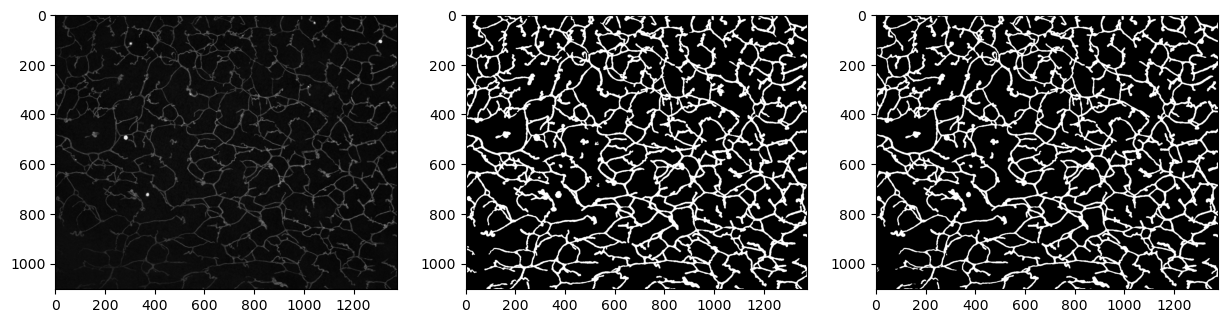

In [25]:
x, y = ds_valid[0]
with torch.no_grad():
    output = model(x[None].to('cuda'))[0].to('cpu')
res = output.max(dim=0)[1]

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(x[0], 'gray')
plt.subplot(1, 3, 2)
plt.imshow(y, 'gray')
plt.subplot(1, 3, 3)
plt.imshow(res, 'gray')

In [4]:
insp = torchtrainer.inspector.Inspector(model)
#params = insp.get_params()
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=True):
        output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()


In [3]:
model = torchtrainer.models.resnet_seg.ResNetSeg((3,3,3,3,3), (16,32,64,32,16))
#torchtrainer.profiling.benchmark_model(model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True)
torchtrainer.profiling.benchmark_model(model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=True)

Unsupported operator aten::add_ encountered 50 time(s)
Unsupported operator aten::batch_norm encountered 35 time(s)
Unsupported operator aten::add_ encountered 50 time(s)


{'params': 0.356336,
 'activations': 0.588251136,
 'flops': 188.584296448,
 'memory': 2.095466136932373,
 'time_cpu': 0.013999462127685547,
 'time_gpu': 0.09398822021484375,
 'info': ['params: M',
  'activations: G',
  'flops: G',
  'memory: GiB',
  'time_cpu: s',
  'time_gpu: s']}

In [3]:
import torchtrainer
import torch

model = torchtrainer.models.resunet.ResUNet((1,1,1,1,1), (16,32,64,128,256))
torchtrainer.profiling.benchmark_model(model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
#torchtrainer.profiling.benchmark_model(model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
#model

{'params': 0.0,
 'activations': 0.0,
 'flops': 0.0,
 'memory': 2.712401866912842,
 'time_cpu': 0.006001472473144531,
 'time_gpu': 0.09777152252197266,
 'info': ['params: M',
  'activations: G',
  'flops: G',
  'memory: GiB',
  'time_cpu: s',
  'time_gpu: s']}

In [5]:
stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('litseg.model.conv1',
  tensor(-76.2500, dtype=torch.float16),
  tensor(78.8125, dtype=torch.float16)),
 ('litseg.model.bn1',
  tensor(-26.9375, dtype=torch.float16),
  tensor(22.3438, dtype=torch.float16)),
 ('litseg.model.relu',
  tensor(0., dtype=torch.float16),
  tensor(22.3438, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.conv1',
  tensor(-171.6250, dtype=torch.float16),
  tensor(149.7500, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.bn1',
  tensor(-31.3750, dtype=torch.float16),
  tensor(15.6094, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.relu1',
  tensor(0., dtype=torch.float16),
  tensor(15.6094, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.conv2',
  tensor(-95.2500, dtype=torch.float16),
  tensor(68.6875, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.bn2',
  tensor(-27.6562, dtype=torch.float16),
  tensor(18.0938, dtype=torch.float16)),
 ('litseg.model.encoder.stage_0.0.relu2',
  tensor(0., dtype=torch.float16),
  

In [2]:
from dataset import create_datasets
import lightning.pytorch as pl
pl.seed_everything(12, workers=True)
ds_train, ds_valid, _ = create_datasets(params['img_dir'], params['label_dir'], params['crop_size'], params['train_val_split'], use_simple=not params['use_transforms'])
img, _ = ds_valid[210]
img_or, _ = ds_valid.get_item(210)

Global seed set to 12


In [ ]:
import os
from PIL import Image
import numpy as np
import cv2

root = 'H:/datasets/segmentation/vessel/maximum_projection/images'
files = os.listdir(root)
clahe_mat = cv2.createCLAHE(clipLimit=3., tileGridSize=(16, 16))
bins = range(257)
hists = []
mean = 0
std = 0
for idx, file in enumerate(files):
    if idx%100==0:
        print(idx)
    img = np.array(Image.open(root+'/'+file))
    #img_res = clahe_mat.apply(img)
    mean += img.mean()
    std += img.std()

In [38]:
load_pl = False

if load_pl:
    import train_lightning
    model = train_lightning.LitSeg.load_from_checkpoint("logs/version_1/checkpoints/last.ckpt")
    model.to('cuda')
    model.eval()
else:
    checkpoint = torch.load(params['checkpoint_file'])
    model = torchtrainer.models.resnet_seg.ResNetSeg(params['model_layers'], params['model_channels'])
    model.to('cuda')
    model.load_state_dict(checkpoint["model"])
    model.eval();


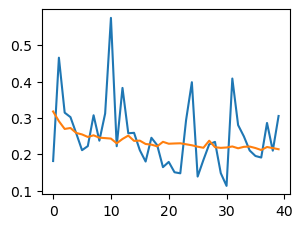

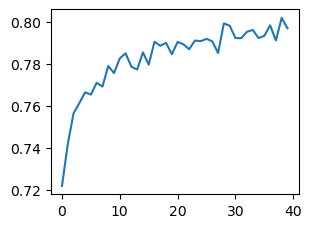

In [47]:
epochs, data = zip(*logger.data.items())
tl, vl, iou, _, _ = zip(*data)
plt.figure()
plt.plot(tl)
plt.plot(vl)
plt.figure()
plt.plot(iou)

In [ ]:
checkpoint = torch.load(params['checkpoint_file'])
model.to('cpu')
model.load_state_dict(checkpoint["model"])
model.eval()
img, label = ds_valid[0]
with torch.no_grad():
    res = model(img[None])[0]
    pred_label = res.argmax(dim=0)

plt.figure()
plt.imshow(img[0], 'gray')
plt.figure()
plt.imshow(pred_label, 'gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(label, 'gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(torch.nn.functional.softmax(res, dim=0)[1], 'gray', vmin=0, vmax=1)

### Tests

In [4]:
def gather_data(data, is_act=False):
    """Change data returned by the Inspector class from layer:stat to stat:layer."""

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)
    data_dict = {
        'mean':mean,
        'std':std,
        'min':min,
        'max':max,
        'names':names
    }

    return data_dict

def summarize_data(inspector):
    """Print the smallest and largest mean and standard deviation of each layer in the network. """

    params = inspector.get_params()
    grads = inspector.get_grads()
    acts = inspector.get_activations()
    param_dict = gather_data(params, is_act=False)
    grads_dict = gather_data(grads, is_act=False)
    acts_dict = gather_data(acts, is_act=True)
    data_dict = {'Param data':param_dict, 'Grad data':grads_dict, 'Activation data':acts_dict}
    print('Summary of data:')
    for data_type, data in data_dict.items():
        min_mean, max_mean = min(data['mean']), max(data['mean'])
        min_std, max_std = min(data['std']), max(data['std'])
        print(f'{data_type}: Smallest mean: {min_mean}, Largest mean: {max_mean}, Smallest std: {min_std}, Largest std: {max_std}')
        

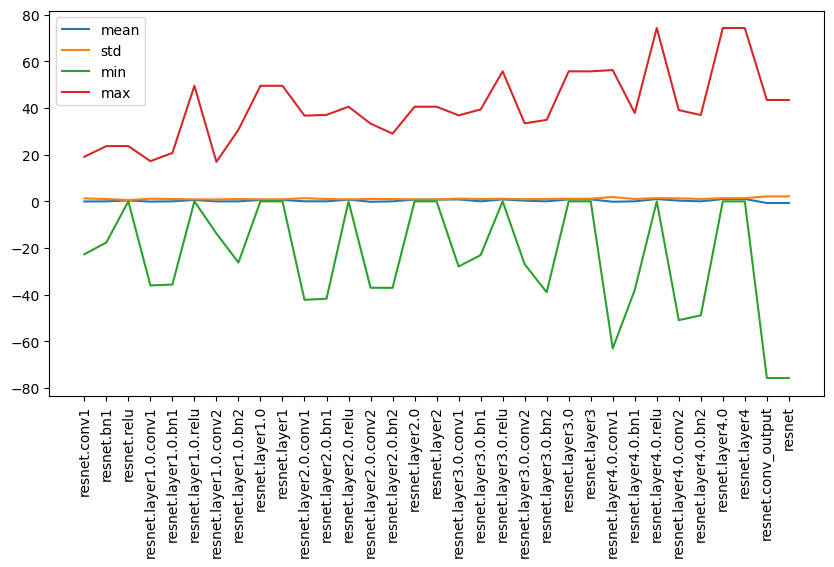

In [103]:
def plot_data(data, is_act=False):

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)

    plt.figure(figsize=(10, 5))
    plt.plot(names, mean, label='mean')
    plt.plot(names, std, label='std')
    plt.plot(names, min, label='min')
    plt.plot(names, max, label='max')
    plt.xticks(rotation=90)
    plt.legend()

insp = inspector.Inspector(model, agg_func=inspector.agg_func_stats)
insp.start_tracking_activations()
params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()
plot_data(acts, is_act=True)


In [ ]:
def create_histograms(data, is_act=False):

    min_val = torch.inf
    max_val = -torch.inf
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        min = value.min()
        max = value.max()
        if min<min_val:
            min_val = min
        if max>max_val:
            max_val = max

    bins = torch.linspace(min_val, max_val, 100)
    hists = {}
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        hist, _ = torch.histogram(value, bins)
        hists[name] = hist
        
    return hists, bins

def plot_histograms(hists, bins, figsize=(8, 20)):

    num_subplots = len(hists)
    plt.figure(figsize=figsize)
    for idx, (name, hist) in enumerate(hists.items()):
        plt.subplot(num_subplots, 1, idx+1)
        plt.plot(bins[:-1], hist)
        plt.title(name)
    plt.tight_layout()

params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()

hists, bins = create_histograms(params, True)
plot_histograms(hists, bins)